In [1]:
import numpy as np


class GaussianRandomFieldForward:
    """
    Simple Gaussian random field based on a finite expansion:
        u(x; theta) = sum_j theta_j * phi_j(x),

    where phi_j(x) are Gaussian bumps centered at given basis_centers.

    Parameters
    ----------
    basis_centers : ndarray of shape (M, dim)
        Centers c_j of the Gaussian basis functions.
    lengthscale : float
        Lengthscale ℓ of the Gaussian basis:
            phi_j(x) = exp(-||x - c_j||^2 / (2 ℓ^2)).
    """

    def __init__(self, basis_centers: np.ndarray, lengthscale: float):
        self.basis_centers = np.asarray(basis_centers, dtype=float)
        self.lengthscale = float(lengthscale)
        self.dim = self.basis_centers.shape[1]
        self.num_basis = self.basis_centers.shape[0]

    def field_values(self, theta: np.ndarray, points: np.ndarray) -> np.ndarray:
        """
        Evaluate the random field u(x; theta) at given spatial points.

        Parameters
        ----------
        theta : ndarray of shape (M,)
            Coefficients in the Gaussian basis; prior will be N(0, I).
        points : ndarray of shape (N, dim)
            Spatial locations x_i where the field is evaluated.

        Returns
        -------
        values : ndarray of shape (N,)
            Field values u(x_i; theta).
        """
        theta = np.asarray(theta, dtype=float)
        points = np.asarray(points, dtype=float)

        # points: (N, dim), centers: (M, dim)
        diff = points[:, None, :] - self.basis_centers[None, :, :]
        sqdist = np.sum(diff ** 2, axis=2)  # (N, M)
        phi = np.exp(-0.5 * sqdist / (self.lengthscale ** 2))  # (N, M)

        return phi @ theta  # (N,)


def log_prior_standard_normal(theta: np.ndarray) -> float:
    """
    Unnormalized log prior for theta ~ N(0, I).

    Parameters
    ----------
    theta : ndarray of shape (M,)

    Returns
    -------
    log_p : float
        log π(θ) up to an additive constant.
    """
    theta = np.asarray(theta, dtype=float)
    return -0.5 * np.dot(theta, theta)


def log_likelihood_iid_gaussian(y_obs: np.ndarray,
                                y_pred: np.ndarray,
                                noise_sigma: float) -> float:
    """
    Unnormalized log-likelihood for iid Gaussian noise:
        y_obs = y_pred + ε,  ε ~ N(0, σ² I).

    Parameters
    ----------
    y_obs : ndarray of shape (N,)
        Observed measurements.
    y_pred : ndarray of shape (N,)
        Model predictions at the same locations.
    noise_sigma : float
        Standard deviation σ of observation noise.

    Returns
    -------
    log_like : float
        log L(y | θ) up to an additive constant.
    """
    y_obs = np.asarray(y_obs, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    sigma2 = noise_sigma ** 2
    residual = y_obs - y_pred
    return -0.5 * np.sum(residual ** 2) / sigma2


def make_log_posterior(forward_model: GaussianRandomFieldForward,
                       measurement_points: np.ndarray,
                       y_obs: np.ndarray,
                       noise_sigma: float):
    """
    Build a closure log_posterior(theta) combining prior and likelihood.

    Parameters
    ----------
    forward_model : GaussianRandomFieldForward
        Object that provides field_values(theta, points).
    measurement_points : ndarray of shape (N, dim)
        Locations of observed measurements.
    y_obs : ndarray of shape (N,)
        Observed values.
    noise_sigma : float
        Observation noise σ.

    Returns
    -------
    log_post : callable
        Function log_post(theta) -> float.
    """

    measurement_points = np.asarray(measurement_points, dtype=float)
    y_obs = np.asarray(y_obs, dtype=float)

    def log_post(theta: np.ndarray) -> float:
        """
        Unnormalized log-posterior log π(θ | y) = log π(θ) + log L(y | θ).
        """
        lp = log_prior_standard_normal(theta)
        y_pred = forward_model.field_values(theta, measurement_points)
        ll = log_likelihood_iid_gaussian(y_obs, y_pred, noise_sigma)
        return lp + ll

    return log_post


def metropolis_hastings(log_posterior,
                        theta_init: np.ndarray,
                        n_samples: int,
                        proposal_std: float,
                        burnin: int = 0,
                        thinning: int = 1,
                        random_state=None):
    """
    Simple Random Walk Metropolis-Hastings sampler.

    Parameters
    ----------
    log_posterior : callable
        Function taking theta and returning log π(θ | y) up to constant.
    theta_init : ndarray of shape (M,)
        Initial state of the chain.
    n_samples : int
        Number of samples to *return* after burn-in and thinning.
    proposal_std : float
        Standard deviation of Gaussian proposal:
            θ' = θ + N(0, proposal_std² I).
    burnin : int, optional
        Number of initial steps discarded as burn-in.
    thinning : int, optional
        Keep every 'thinning'-th sample after burn-in.
    random_state : int or np.random.Generator, optional
        Seed or external random generator.

    Returns
    -------
    samples : ndarray of shape (n_samples, M)
        Posterior samples of θ.
    log_posts : ndarray of shape (n_samples,)
        Corresponding log-posterior values.
    accept_rate : float
        Overall acceptance rate of the MH chain.
    """
    theta_curr = np.asarray(theta_init, dtype=float)
    dim = theta_curr.size

    if isinstance(random_state, np.random.Generator):
        rng = random_state
    else:
        rng = np.random.default_rng(random_state)

    logp_curr = log_posterior(theta_curr)

    # Total steps to run (include burn-in and thinning)
    total_needed = burnin + n_samples * thinning

    samples = np.zeros((n_samples, dim))
    log_posts = np.zeros(n_samples)
    accepts = 0
    kept = 0

    for step in range(total_needed):
        proposal = theta_curr + proposal_std * rng.standard_normal(size=dim)
        logp_prop = log_posterior(proposal)

        log_alpha = logp_prop - logp_curr
        if np.log(rng.uniform()) < log_alpha:
            theta_curr = proposal
            logp_curr = logp_prop
            accepts += 1

        if step >= burnin and (step - burnin) % thinning == 0:
            samples[kept, :] = theta_curr
            log_posts[kept] = logp_curr
            kept += 1

    accept_rate = accepts / float(total_needed)
    return samples, log_posts, accept_rate



In [3]:

# ======================================================================
# Example: 2D square [-5, 5]^2 with Gaussian basis ("sum of exp" field)
# ======================================================================


rng = np.random.default_rng(123)

# --- Define domain, basis, and forward model ---
# Basis centers: 3x3 grid over [-5, 5]^2
grid_1d = np.linspace(-5.0, 5.0, 3)
cx, cy = np.meshgrid(grid_1d, grid_1d, indexing="xy")
basis_centers = np.column_stack([cx.ravel(), cy.ravel()])  # (9, 2)

lengthscale = 2.0
forward_model = GaussianRandomFieldForward(basis_centers, lengthscale)
num_params = forward_model.num_basis

# --- Measurement points and synthetic data ---
num_measurements = 30
measurement_points = rng.uniform(-5.0, 5.0,
                                    size=(num_measurements, 2))

# "True" parameter for synthetic experiment
theta_true = rng.standard_normal(size=num_params)

noise_sigma = 0.1
clean_data = forward_model.field_values(theta_true, measurement_points)
y_obs = clean_data + noise_sigma * rng.standard_normal(size=num_measurements)

# --- Build posterior and run MH sampler ---
log_post = make_log_posterior(
    forward_model=forward_model,
    measurement_points=measurement_points,
    y_obs=y_obs,
    noise_sigma=noise_sigma,
)

theta_init = np.zeros(num_params)
n_samples = 20000
proposal_std = 0.2

samples, log_posts, acc_rate = metropolis_hastings(
    log_posterior=log_post,
    theta_init=theta_init,
    n_samples=n_samples,
    proposal_std=proposal_std,
    burnin=1000,
    thinning=2,
    random_state=rng,
)

print(f"Posterior samples shape: {samples.shape}")
print(f"Posterior log-values shape: {log_posts.shape}")
print(f"Acceptance rate: {acc_rate:.3f}")
print(f"True theta (first 5):     {theta_true[:5]}")
print(f"Posterior mean (first 5): {samples.mean(axis=0)[:5]}")

Posterior samples shape: (20000, 9)
Posterior log-values shape: (20000,)
Acceptance rate: 0.011
True theta (first 5):     [-0.54308414 -0.55861504 -0.31648283 -0.46063974 -1.43626975]
Posterior mean (first 5): [-0.47870351 -0.5385405  -0.24255848 -0.49266468 -1.45688094]


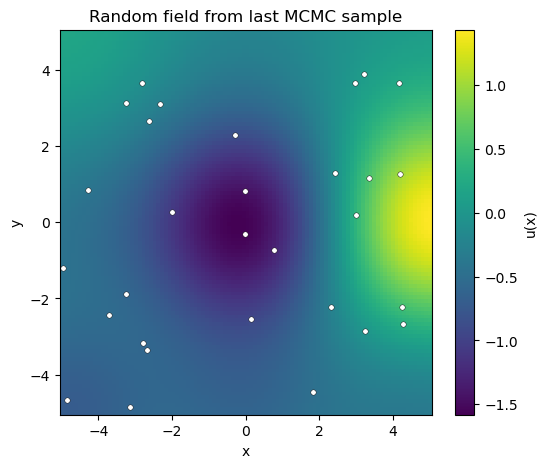

In [5]:
import matplotlib.pyplot as plt

theta_last = samples[-1]
grid_dense = np.linspace(-5.0, 5.0, 100)
xx, yy = np.meshgrid(grid_dense, grid_dense, indexing="xy")
grid_points = np.column_stack([xx.ravel(), yy.ravel()])
field_last = forward_model.field_values(theta_last, grid_points).reshape(xx.shape)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.pcolormesh(xx, yy, field_last, shading="auto", cmap="viridis")
ax.scatter(measurement_points[:, 0], measurement_points[:, 1],
           s=15, c="white", edgecolors="k", linewidths=0.3)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Random field from last MCMC sample")
fig.colorbar(im, ax=ax, label="u(x)")
plt.show()

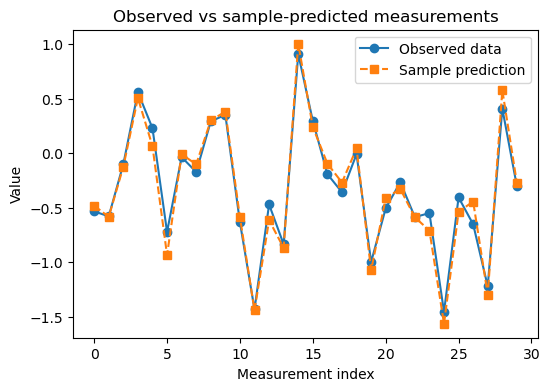

In [6]:
sample_pred = forward_model.field_values(theta_last, measurement_points)

fig, ax = plt.subplots(figsize=(6, 4))
indices = np.arange(num_measurements)
ax.plot(indices, y_obs, "o-", label="Observed data")
ax.plot(indices, sample_pred, "s--", label="Sample prediction")
ax.set_xlabel("Measurement index")
ax.set_ylabel("Value")
ax.set_title("Observed vs sample-predicted measurements")
ax.legend()
plt.show()